In [120]:
import re
import textract
text = textract.process('data/reports/apmm-sustainability-report-a4_2017.pdf')
text = re.split(b'\s{4,}',text)
text = [sentence.decode().replace('\n','').replace('\r',' ') for sentence in text if len(sentence)>100]
text[0]

'ABOUT THE REPORT This report covers activities in the 2017 calendar year. Our approach to reporting is to focus on material issues and activities, in line with stakeholder concerns and relevance in terms of context, completeness and balance. We strive for optimal accuracy, timeliness, clarity and reliability in the way we communicate. This report also represents our statutory statement on social responsibility and underrepresented gender in accordance with sections §99a & b of the Danish Financial Statements Act. The A.P. Moller - Maersk Sustainability Accounting Principles can be downloaded here: maersk.com/ business/sustainability/sustainabilityreports-and-publications/reports Previous years’ data and our UN Global Compact Communication on Progress table are also available online. Please visit maersk.com/business/ sustainability/sustainability-reportsand-publications/reports'

In [121]:
# Hard coded report date for now 

file_date = '2017-12-31'

In [122]:
# tested in transformers==4.18.0 
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)



In [123]:
results = [nlp(paragraph) for paragraph in text]

In [124]:
finbert_sentiment = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer_sentiment = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp_sentiment = pipeline("text-classification", model=finbert_sentiment, tokenizer=tokenizer_sentiment)
results_sentiment = [nlp_sentiment(paragraph) for paragraph in text]


In [125]:
results[0][0]['score']

0.7733378410339355

In [126]:
for i in range(len(results)):
    if results_sentiment[i][0]['label']=='Neutral':
        results[i][0]['score'] = 0
    if results_sentiment[i][0]['label']=='Positive':
        results[i][0]['score'] = results[i][0]['score'] * results_sentiment[i][0]['score'] 
    if results_sentiment[i][0]['label']=='Negative':
        results[i][0]['score'] = results[i][0]['score'] * (-1) * results_sentiment[i][0]['score'] 
    
        

In [127]:
final_score = {}
sumE = []
sumS = []
sumG = []
for i in range(len(results)):
    if results[i][0]['score']!=0:
        if results[i][0]['label']=='Social':
            sumS.append(results[i][0]['score'])
        if results[i][0]['label']=='Environmental':
            sumE.append(results[i][0]['score'])
        if results[i][0]['label']=='Governance':
            sumG.append(results[i][0]['score'])
            
            

In [128]:
def mean_list(lst):
    return sum(lst) / len(lst)


In [129]:
esg_score = {'date': file_date, 'E':mean_list(sumE),'S':mean_list(sumS),'G':mean_list(sumG)}

In [130]:
esg_score

{'date': '2017-12-31',
 'E': 0.2766155139328282,
 'S': 0.5989943795969318,
 'G': 0.2247681380133394}

This report represents one point in time. We can gather all the news we can (manually or by scraping) over a period from one company(PDF quarterly reports, audio, news, tweets and reddits ). We run the same script on the data we gathered and build multiple esg_score points. Then we plot the time series and study its relevance to stock prices (and multiple indicators like moving average, momentum) as a measure of the model's performance. It will also help us tweak weights for each news source and explore a more sophisticated scoring system.

In [131]:
# sample end result
import pandas as pd
import numpy as np
series = pd.date_range(start='2016-01-01', end='2020-12-31', freq='D')


In [132]:
df = pd.DataFrame(index=series)
df['E'] = np.random.randint(-100, 100, size=(len(series)))/100
df['S'] = np.random.randint(-100, 100, size=(len(series)))/100
df['G'] = np.random.randint(-100, 100, size=(len(series)))/100
df

,E,S,G
2016-01-01,-0.11,0.69,-0.74
2016-01-02,-0.28,0.37,0.32
2016-01-03,-0.39,0.23,0.23
2016-01-04,0.23,0.71,0.73
2016-01-05,0.49,0.96,-0.85
...,...,...,...
2020-12-27,0.34,-0.78,-0.83
2020-12-28,0.06,0.12,-0.22
2020-12-29,0.40,-0.49,-0.80
2020-12-30,0.09,-0.62,0.35


In [133]:
df['E_score'] = df['E'].cumsum()
df['S_score'] = df['S'].cumsum()
df['G_score'] = df['G'].cumsum()

df

,E,S,G,E_score,S_score,G_score
2016-01-01,-0.11,0.69,-0.74,-0.11,0.69,-0.74
2016-01-02,-0.28,0.37,0.32,-0.39,1.06,-0.42
2016-01-03,-0.39,0.23,0.23,-0.78,1.29,-0.19
2016-01-04,0.23,0.71,0.73,-0.55,2.00,0.54
2016-01-05,0.49,0.96,-0.85,-0.06,2.96,-0.31
...,...,...,...,...,...,...
2020-12-27,0.34,-0.78,-0.83,-54.54,30.63,-41.55
2020-12-28,0.06,0.12,-0.22,-54.48,30.75,-41.77
2020-12-29,0.40,-0.49,-0.80,-54.08,30.26,-42.57
2020-12-30,0.09,-0.62,0.35,-53.99,29.64,-42.22


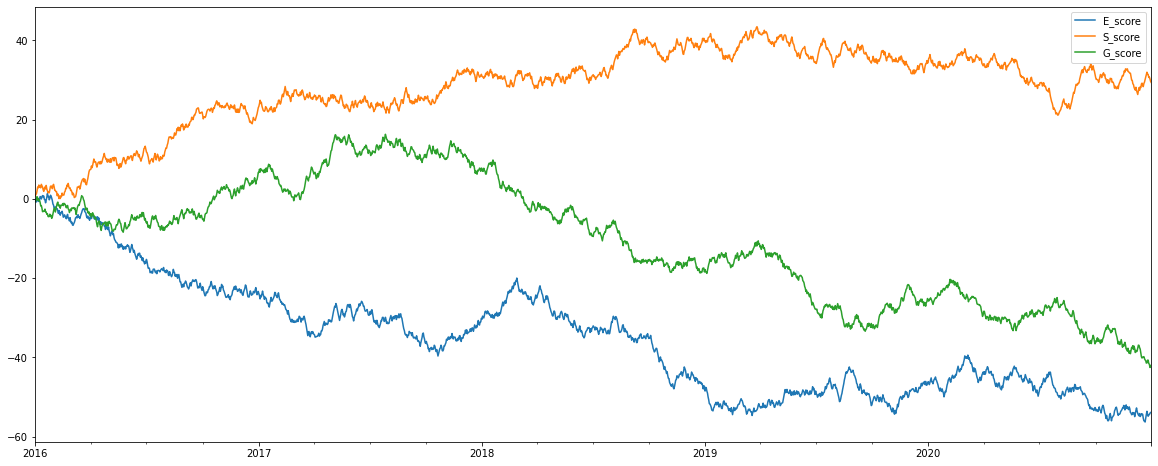

In [134]:

df.plot(use_index=True, y=['E_score','S_score','G_score'], figsize=(20,8));